# Introduction to Digital Forensics - Assignment 3

### Group 1
- Simge Bilen       s2532239
- Mark Boom         s2552469
- Tom Essers        s2484765
- Baran Gülbey      s2616394
- Jelmer Hofman     s2460653
- Stijn Schuurman   s2620162

In [ ]:
!pip3 install pandas
!pip3 install matplotlib
!pip3 install openpyxl

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import collections

In [3]:
#csv file
file =  'jabber_chat_2021_2022_translated.csv'

df = pd.read_csv(file)

(array([ 313.,  408.,  321.,  388.,  249.,  531.,  839., 1977., 2759.,
        3221., 3200., 3582., 4503., 5233., 5257., 4545., 4723., 4946.,
        4393., 3089., 2940., 1952., 1404.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.]),
 <BarContainer object of 23 artists>)

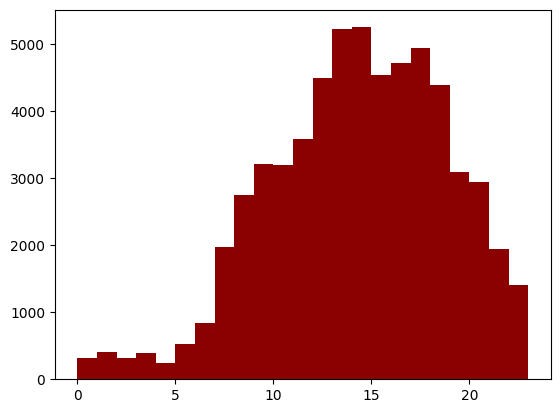

In [4]:
df = pd.read_csv(file, usecols=['ts'])
hours = []
for index, row in df.iterrows():
    hours.append(int(row.ts[11:13]))
plt.hist(hours, color="darkred", bins=range(0, 24))

<BarContainer object of 10 artists>

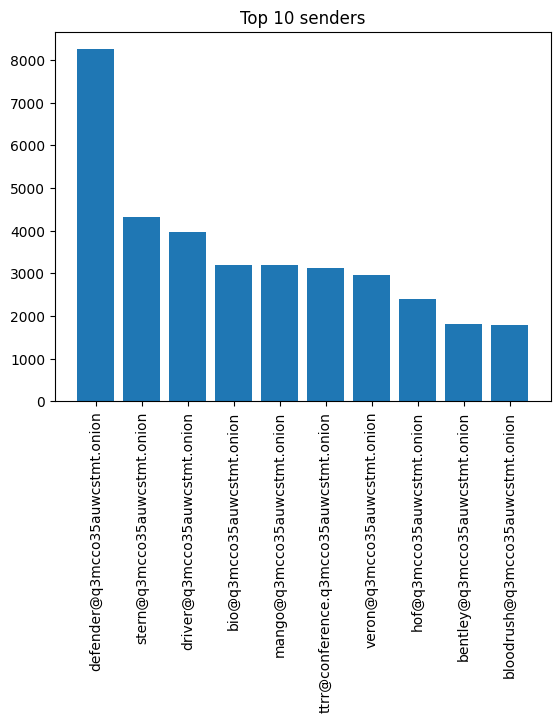

In [5]:
df = pd.read_csv(file, usecols=['sender'])
senders = []
for index, row in df.iterrows():
    senders.append(row.sender)

frequency = collections.Counter(senders)

sendersList = frequency.keys()
frequencyList = frequency.values()

sendersOrdered = [x for _,x in sorted(zip(frequencyList,sendersList), reverse=True)]
frequenciesOrdered = []
# Z is ordered list of most used emails as senders
for x in sendersOrdered:
    frequenciesOrdered.append(frequency.get(x))

plt.title("Top 10 senders")
plt.xticks(rotation=90)
plt.bar(sendersOrdered[:10], frequenciesOrdered[:10])